## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 7 slices in the middle
* slide inference

In [1]:
idxs = range(65)
idxs

range(0, 65)

In [2]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [3]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [4]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [6]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [7]:
import segmentation_models_pytorch as smp

In [8]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [9]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp015'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 7 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [12]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [13]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [14]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [15]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    # mid = 65 // 2
    # start = mid - CFG.in_chans // 2
    # end = mid + CFG.in_chans // 2
    # idxs = range(start, end)
    idxs = [26,28,30,32,34,36,38]

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [16]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [17]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [19]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [20]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [21]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [22]:
train_dataset[0][0].shape

torch.Size([7, 224, 224])

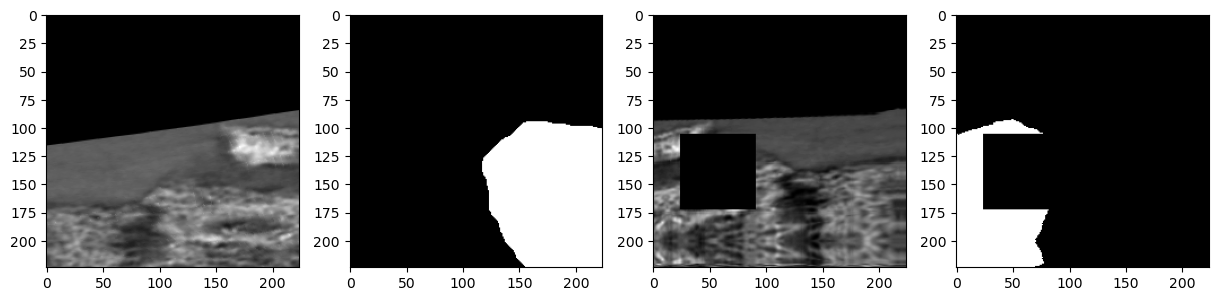

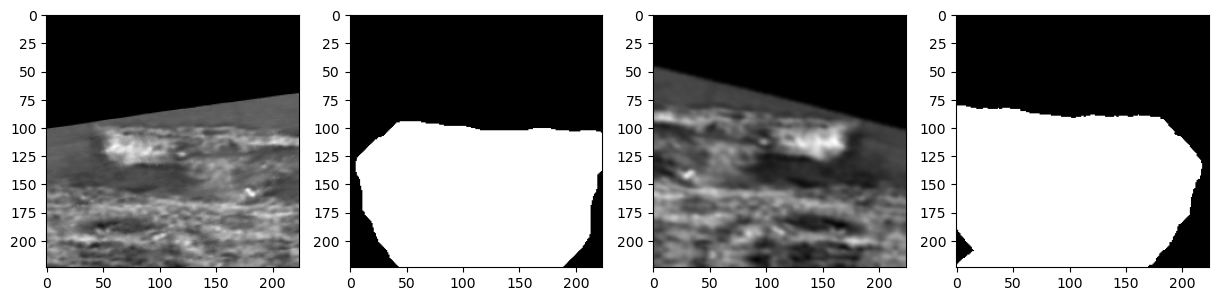

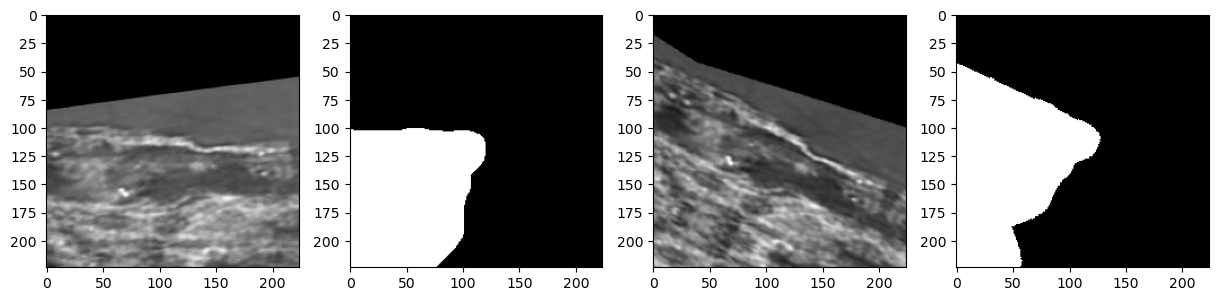

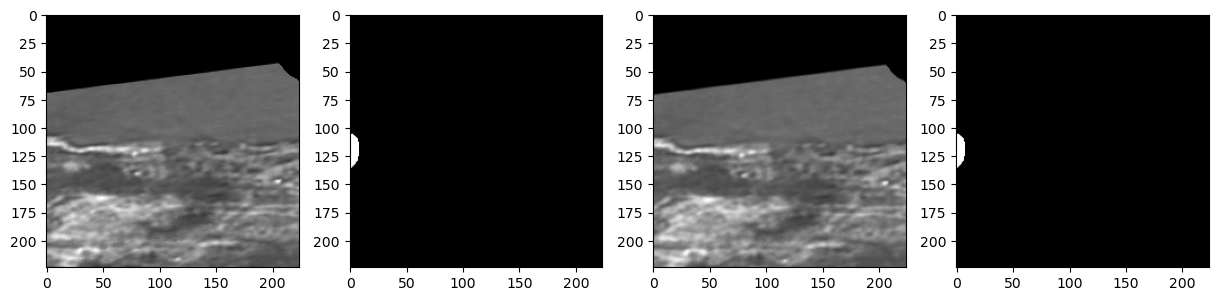

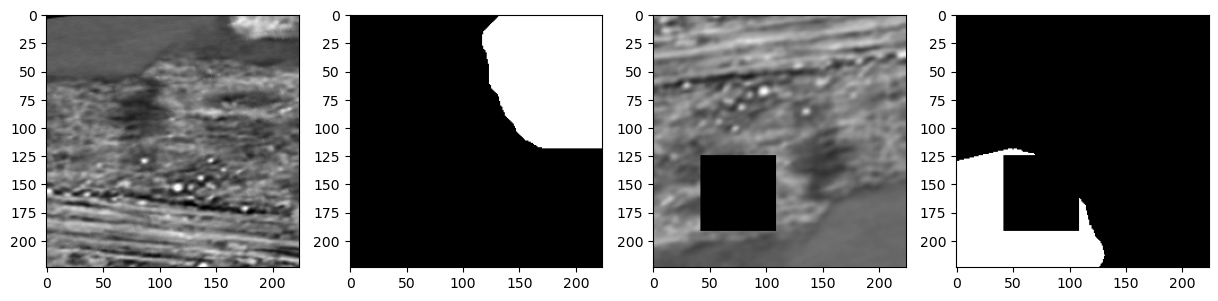

In [23]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [24]:
del plot_dataset
gc.collect()

48120

## model

In [25]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [26]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [27]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [28]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [30]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [32]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [33]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [34]:
fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.1510625904705339
th: 0.15, fbeta: 0.16572527471201842
th: 0.2, fbeta: 0.19074356946906218
th: 0.25, fbeta: 0.23044341442793306
th: 0.3, fbeta: 0.2758935259774858
th: 0.35, fbeta: 0.31441209647740653
th: 0.4, fbeta: 0.3390446314748826
th: 0.45, fbeta: 0.3298916069729158


best_th: 0.4, fbeta: 0.3390446314748826
Epoch 1 - avg_train_loss: 0.3967  avg_val_loss: 0.2886  time: 240s
Epoch 1 - avgScore: 0.3390
Epoch 1 - Save Best Score: 0.3390 Model
Epoch 1 - Save Best Loss: 0.2886 Model


th: 0.5, fbeta: 0.21660037718401168


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.1639138448092397
th: 0.15, fbeta: 0.2127549131625554
th: 0.2, fbeta: 0.2956733116104945
th: 0.25, fbeta: 0.35080604400389076
th: 0.3, fbeta: 0.3776354118215666
th: 0.35, fbeta: 0.39532833561212605
th: 0.4, fbeta: 0.40256581138399233
th: 0.45, fbeta: 0.38037861056855415


best_th: 0.4, fbeta: 0.40256581138399233
Epoch 2 - avg_train_loss: 0.3076  avg_val_loss: 0.2465  time: 239s
Epoch 2 - avgScore: 0.4026
Epoch 2 - Save Best Score: 0.4026 Model
Epoch 2 - Save Best Loss: 0.2465 Model


th: 0.5, fbeta: 0.3056942357479581


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.24812012420387372
th: 0.15, fbeta: 0.29947208966375777
th: 0.2, fbeta: 0.34764049265060576
th: 0.25, fbeta: 0.3865165780136397
th: 0.3, fbeta: 0.42346370846434783
th: 0.35, fbeta: 0.4392288551547344
th: 0.4, fbeta: 0.4431616965528752
th: 0.45, fbeta: 0.4355189327907693


best_th: 0.4, fbeta: 0.4431616965528752
Epoch 3 - avg_train_loss: 0.2676  avg_val_loss: 0.2059  time: 239s
Epoch 3 - avgScore: 0.4432
Epoch 3 - Save Best Score: 0.4432 Model
Epoch 3 - Save Best Loss: 0.2059 Model


th: 0.5, fbeta: 0.4029980317919176


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2638037933743858
th: 0.15, fbeta: 0.31904752193847197
th: 0.2, fbeta: 0.37046429158671057
th: 0.25, fbeta: 0.41665131047701065
th: 0.3, fbeta: 0.4473004216071621
th: 0.35, fbeta: 0.46595866497093186
th: 0.4, fbeta: 0.4814450267203771
th: 0.45, fbeta: 0.48245883164183595


best_th: 0.45, fbeta: 0.48245883164183595
Epoch 4 - avg_train_loss: 0.2435  avg_val_loss: 0.2027  time: 240s
Epoch 4 - avgScore: 0.4825
Epoch 4 - Save Best Score: 0.4825 Model
Epoch 4 - Save Best Loss: 0.2027 Model


th: 0.5, fbeta: 0.4722154308376288


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23344238987079377
th: 0.15, fbeta: 0.2838950032568339
th: 0.2, fbeta: 0.3376703479694728
th: 0.25, fbeta: 0.37899593639633256
th: 0.3, fbeta: 0.4108662490769906
th: 0.35, fbeta: 0.44272010699207026
th: 0.4, fbeta: 0.4709183647707503
th: 0.45, fbeta: 0.4912922143838064


best_th: 0.5, fbeta: 0.5037660529580916
Epoch 5 - avg_train_loss: 0.2301  avg_val_loss: 0.2103  time: 239s
Epoch 5 - avgScore: 0.5038
Epoch 5 - Save Best Score: 0.5038 Model
Epoch 5 - Save Best Loss: 0.2103 Model


th: 0.5, fbeta: 0.5037660529580916


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2752558547255195
th: 0.15, fbeta: 0.3197113551692113
th: 0.2, fbeta: 0.3538258143501174
th: 0.25, fbeta: 0.3856368412801255
th: 0.3, fbeta: 0.4135427165819541
th: 0.35, fbeta: 0.43765640687849655
th: 0.4, fbeta: 0.45784811858813285
th: 0.45, fbeta: 0.4790615894502884


best_th: 0.5, fbeta: 0.4944097513235554
Epoch 6 - avg_train_loss: 0.2172  avg_val_loss: 0.2107  time: 238s
Epoch 6 - avgScore: 0.4944


th: 0.5, fbeta: 0.4944097513235554


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26311791601320594
th: 0.15, fbeta: 0.29979418699914173
th: 0.2, fbeta: 0.3317021061840179
th: 0.25, fbeta: 0.35684232684545797
th: 0.3, fbeta: 0.3775035746745431
th: 0.35, fbeta: 0.3997926225481306
th: 0.4, fbeta: 0.424344518035503
th: 0.45, fbeta: 0.4460431032528353


best_th: 0.5, fbeta: 0.46373099999946427
Epoch 7 - avg_train_loss: 0.2051  avg_val_loss: 0.2299  time: 239s
Epoch 7 - avgScore: 0.4637


th: 0.5, fbeta: 0.46373099999946427


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29482940541741903
th: 0.15, fbeta: 0.33650220421838445
th: 0.2, fbeta: 0.37164557786608976
th: 0.25, fbeta: 0.4012361272168269
th: 0.3, fbeta: 0.42860775801194295
th: 0.35, fbeta: 0.45335810869018184
th: 0.4, fbeta: 0.4757448286905451
th: 0.45, fbeta: 0.4938389399726744


best_th: 0.5, fbeta: 0.5086511896399638
Epoch 8 - avg_train_loss: 0.1943  avg_val_loss: 0.2131  time: 239s
Epoch 8 - avgScore: 0.5087
Epoch 8 - Save Best Score: 0.5087 Model
Epoch 8 - Save Best Loss: 0.2131 Model


th: 0.5, fbeta: 0.5086511896399638


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3417760447416375
th: 0.15, fbeta: 0.38756549010512276
th: 0.2, fbeta: 0.4212696194679236
th: 0.25, fbeta: 0.4482077401614388
th: 0.3, fbeta: 0.46889142216451657
th: 0.35, fbeta: 0.4859599332881799
th: 0.4, fbeta: 0.49938228120057593
th: 0.45, fbeta: 0.5080370892988212


best_th: 0.5, fbeta: 0.5115148246459431
Epoch 9 - avg_train_loss: 0.1827  avg_val_loss: 0.2205  time: 239s
Epoch 9 - avgScore: 0.5115
Epoch 9 - Save Best Score: 0.5115 Model
Epoch 9 - Save Best Loss: 0.2205 Model


th: 0.5, fbeta: 0.5115148246459431


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2333534292442162
th: 0.15, fbeta: 0.2613111242963687
th: 0.2, fbeta: 0.2883740504678989
th: 0.25, fbeta: 0.31422439578086253
th: 0.3, fbeta: 0.3424305281220343
th: 0.35, fbeta: 0.3687887755787919
th: 0.4, fbeta: 0.39469515262853466
th: 0.45, fbeta: 0.4217946930454769


best_th: 0.5, fbeta: 0.44583384937740084
Epoch 10 - avg_train_loss: 0.1740  avg_val_loss: 0.2477  time: 241s
Epoch 10 - avgScore: 0.4458


th: 0.5, fbeta: 0.44583384937740084


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2953768222540968
th: 0.15, fbeta: 0.323187935473804
th: 0.2, fbeta: 0.3460162439464287
th: 0.25, fbeta: 0.3690669846941643
th: 0.3, fbeta: 0.3895354901689243
th: 0.35, fbeta: 0.4095634405232526
th: 0.4, fbeta: 0.4281105748444081
th: 0.45, fbeta: 0.4459025156522806


best_th: 0.5, fbeta: 0.4619592991350623
Epoch 11 - avg_train_loss: 0.1595  avg_val_loss: 0.2512  time: 241s
Epoch 11 - avgScore: 0.4620


th: 0.5, fbeta: 0.4619592991350623


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26963348876851534
th: 0.15, fbeta: 0.29201282164384046
th: 0.2, fbeta: 0.31245733431535827
th: 0.25, fbeta: 0.33066673584563944
th: 0.3, fbeta: 0.34918598051511174
th: 0.35, fbeta: 0.36755950211309674
th: 0.4, fbeta: 0.38702965158975033
th: 0.45, fbeta: 0.40484409650413566


best_th: 0.5, fbeta: 0.42240117812868067
Epoch 12 - avg_train_loss: 0.1485  avg_val_loss: 0.2741  time: 238s
Epoch 12 - avgScore: 0.4224


th: 0.5, fbeta: 0.42240117812868067


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.24612026049977892
th: 0.15, fbeta: 0.2714803778220832
th: 0.2, fbeta: 0.29761527317381514
th: 0.25, fbeta: 0.3238707363017029
th: 0.3, fbeta: 0.34723886732766907
th: 0.35, fbeta: 0.3701700843207736
th: 0.4, fbeta: 0.39079433732341246
th: 0.45, fbeta: 0.41185336348766977


best_th: 0.5, fbeta: 0.43218312159310934
Epoch 13 - avg_train_loss: 0.1410  avg_val_loss: 0.2533  time: 241s
Epoch 13 - avgScore: 0.4322


th: 0.5, fbeta: 0.43218312159310934


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2689398638912099
th: 0.15, fbeta: 0.2959966569336829
th: 0.2, fbeta: 0.32066901664665354
th: 0.25, fbeta: 0.3431004568566722
th: 0.3, fbeta: 0.3628874935969576
th: 0.35, fbeta: 0.38363144358273543
th: 0.4, fbeta: 0.40408132232944827
th: 0.45, fbeta: 0.4228618783605887


best_th: 0.5, fbeta: 0.4409962176122869
Epoch 14 - avg_train_loss: 0.1320  avg_val_loss: 0.2621  time: 241s
Epoch 14 - avgScore: 0.4410


th: 0.5, fbeta: 0.4409962176122869


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2970129358614107
th: 0.15, fbeta: 0.3327644941824553
th: 0.2, fbeta: 0.36351187410640756
th: 0.25, fbeta: 0.39137823341480055
th: 0.3, fbeta: 0.4160733562948239
th: 0.35, fbeta: 0.4375854172509778
th: 0.4, fbeta: 0.4566590118825273
th: 0.45, fbeta: 0.47444470023674107


best_th: 0.5, fbeta: 0.4915271744057314
Epoch 15 - avg_train_loss: 0.1226  avg_val_loss: 0.2322  time: 240s
Epoch 15 - avgScore: 0.4915


th: 0.5, fbeta: 0.4915271744057314


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2589193314998798
th: 0.15, fbeta: 0.28201653441838226
th: 0.2, fbeta: 0.304334133629535
th: 0.25, fbeta: 0.3261330849589816
th: 0.3, fbeta: 0.34754414504363673
th: 0.35, fbeta: 0.3672375268849498
th: 0.4, fbeta: 0.3861882489213538
th: 0.45, fbeta: 0.4038708114312763


best_th: 0.5, fbeta: 0.4225970343930022
Epoch 16 - avg_train_loss: 0.1166  avg_val_loss: 0.2764  time: 241s
Epoch 16 - avgScore: 0.4226


th: 0.5, fbeta: 0.4225970343930022


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3303676267859369
th: 0.15, fbeta: 0.3580967394845246
th: 0.2, fbeta: 0.3808184467414867
th: 0.25, fbeta: 0.40304034968683805
th: 0.3, fbeta: 0.42215593937039975
th: 0.35, fbeta: 0.4407433830190701
th: 0.4, fbeta: 0.4548288064095233


best_th: 0.5, fbeta: 0.47923918166411733
Epoch 17 - avg_train_loss: 0.1096  avg_val_loss: 0.2610  time: 242s
Epoch 17 - avgScore: 0.4792


th: 0.45, fbeta: 0.4666245137289517
th: 0.5, fbeta: 0.47923918166411733


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30722054317752867
th: 0.15, fbeta: 0.33510212618764085
th: 0.2, fbeta: 0.36021353105456894
th: 0.25, fbeta: 0.3851398169786279
th: 0.3, fbeta: 0.4089248395650646
th: 0.35, fbeta: 0.43123561616506556
th: 0.4, fbeta: 0.45155572348130074
th: 0.45, fbeta: 0.46543914689185373


best_th: 0.5, fbeta: 0.4787941822598091
Epoch 18 - avg_train_loss: 0.1040  avg_val_loss: 0.2594  time: 241s
Epoch 18 - avgScore: 0.4788


th: 0.5, fbeta: 0.4787941822598091


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2960514730117889
th: 0.15, fbeta: 0.318018037114071
th: 0.2, fbeta: 0.33926033582054443
th: 0.25, fbeta: 0.36020321852324827
th: 0.3, fbeta: 0.37971834720507874
th: 0.35, fbeta: 0.3963370552911789
th: 0.4, fbeta: 0.4118166832213152
th: 0.45, fbeta: 0.4283058820442878


best_th: 0.5, fbeta: 0.44194128434161256
Epoch 19 - avg_train_loss: 0.0975  avg_val_loss: 0.3006  time: 240s
Epoch 19 - avgScore: 0.4419


th: 0.5, fbeta: 0.44194128434161256


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.317834283899634
th: 0.15, fbeta: 0.3472755617493257
th: 0.2, fbeta: 0.37369375348201567
th: 0.25, fbeta: 0.3987156442471728
th: 0.3, fbeta: 0.41802409889643516
th: 0.35, fbeta: 0.43628287784903247
th: 0.4, fbeta: 0.4523922946877847
th: 0.45, fbeta: 0.4681424832474769


best_th: 0.5, fbeta: 0.4836502941314998
Epoch 20 - avg_train_loss: 0.0911  avg_val_loss: 0.2594  time: 240s
Epoch 20 - avgScore: 0.4837


th: 0.5, fbeta: 0.4836502941314998


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32780768185429343
th: 0.15, fbeta: 0.3570069598625544
th: 0.2, fbeta: 0.38365796990176104
th: 0.25, fbeta: 0.4087353497777396
th: 0.3, fbeta: 0.4293914292084887
th: 0.35, fbeta: 0.4499742459703444
th: 0.4, fbeta: 0.47144567083112465
th: 0.45, fbeta: 0.48678034454125113


best_th: 0.5, fbeta: 0.501719051623726
Epoch 21 - avg_train_loss: 0.0877  avg_val_loss: 0.2730  time: 238s
Epoch 21 - avgScore: 0.5017


th: 0.5, fbeta: 0.501719051623726


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30432091706623726
th: 0.15, fbeta: 0.32810940614965073
th: 0.2, fbeta: 0.35028759068647974
th: 0.25, fbeta: 0.3707744992428243
th: 0.3, fbeta: 0.3880637960986257
th: 0.35, fbeta: 0.40434130513886585
th: 0.4, fbeta: 0.42134856120383235
th: 0.45, fbeta: 0.4379864708111553


best_th: 0.5, fbeta: 0.45465218902802684
Epoch 22 - avg_train_loss: 0.0834  avg_val_loss: 0.2888  time: 243s
Epoch 22 - avgScore: 0.4547


th: 0.5, fbeta: 0.45465218902802684


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32321912691956595
th: 0.15, fbeta: 0.3525572914620444
th: 0.2, fbeta: 0.376931354580498
th: 0.25, fbeta: 0.3996727074784124
th: 0.3, fbeta: 0.4183567870779234
th: 0.35, fbeta: 0.4369192734789267
th: 0.4, fbeta: 0.4559821159276964
th: 0.45, fbeta: 0.472541993843368


best_th: 0.5, fbeta: 0.48686500332898036
Epoch 23 - avg_train_loss: 0.0787  avg_val_loss: 0.2814  time: 241s
Epoch 23 - avgScore: 0.4869


th: 0.5, fbeta: 0.48686500332898036


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3098786654613139
th: 0.15, fbeta: 0.33775701807918684
th: 0.2, fbeta: 0.3598278673627412
th: 0.25, fbeta: 0.37891098182100846
th: 0.3, fbeta: 0.39829801183607544
th: 0.35, fbeta: 0.41594332760416064
th: 0.4, fbeta: 0.4319511538352379
th: 0.45, fbeta: 0.44890822260233226


best_th: 0.5, fbeta: 0.4633284302685538
Epoch 24 - avg_train_loss: 0.0769  avg_val_loss: 0.2903  time: 240s
Epoch 24 - avgScore: 0.4633


th: 0.5, fbeta: 0.4633284302685538


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31490502986452934
th: 0.15, fbeta: 0.3388666851185654
th: 0.2, fbeta: 0.3614911623226572
th: 0.25, fbeta: 0.3836346110815079
th: 0.3, fbeta: 0.4015738475253968
th: 0.35, fbeta: 0.4203334062779518
th: 0.4, fbeta: 0.4376753316635033
th: 0.45, fbeta: 0.45405234184180854


best_th: 0.5, fbeta: 0.4700530428963736
Epoch 25 - avg_train_loss: 0.0731  avg_val_loss: 0.3079  time: 243s
Epoch 25 - avgScore: 0.4701


th: 0.5, fbeta: 0.4700530428963736


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3234952932016305
th: 0.15, fbeta: 0.34989761239093664
th: 0.2, fbeta: 0.3740009000028166
th: 0.25, fbeta: 0.397503037288495
th: 0.3, fbeta: 0.4145635484254329
th: 0.35, fbeta: 0.428769031560662
th: 0.4, fbeta: 0.4433661137225055
th: 0.45, fbeta: 0.4581737406738169


best_th: 0.5, fbeta: 0.4736291028192527
Epoch 26 - avg_train_loss: 0.0702  avg_val_loss: 0.3154  time: 241s
Epoch 26 - avgScore: 0.4736


th: 0.5, fbeta: 0.4736291028192527


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32588507908083636
th: 0.15, fbeta: 0.354401786396638
th: 0.2, fbeta: 0.3803022245755247
th: 0.25, fbeta: 0.404739564126514
th: 0.3, fbeta: 0.4256014765820409
th: 0.35, fbeta: 0.4435247672731465
th: 0.4, fbeta: 0.45759433401298133
th: 0.45, fbeta: 0.47213583518621277


best_th: 0.5, fbeta: 0.48519259645633933
Epoch 27 - avg_train_loss: 0.0684  avg_val_loss: 0.3012  time: 239s
Epoch 27 - avgScore: 0.4852


th: 0.5, fbeta: 0.48519259645633933


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3094819110299565
th: 0.15, fbeta: 0.3330402052305277
th: 0.2, fbeta: 0.35423088810305875
th: 0.25, fbeta: 0.3753346468056152
th: 0.3, fbeta: 0.39363728442339624
th: 0.35, fbeta: 0.4101803004261956
th: 0.4, fbeta: 0.4255503872664827
th: 0.45, fbeta: 0.4406236288984217


best_th: 0.5, fbeta: 0.45738090767530404
Epoch 28 - avg_train_loss: 0.0661  avg_val_loss: 0.3098  time: 243s
Epoch 28 - avgScore: 0.4574


th: 0.5, fbeta: 0.45738090767530404


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3235895915780572
th: 0.15, fbeta: 0.34803506269884116
th: 0.2, fbeta: 0.3701614513789683
th: 0.25, fbeta: 0.39180254806567133
th: 0.3, fbeta: 0.40732259402664894
th: 0.35, fbeta: 0.4230057193327054
th: 0.4, fbeta: 0.4382869908220757
th: 0.45, fbeta: 0.4539802745332664


best_th: 0.5, fbeta: 0.46709686430133607
Epoch 29 - avg_train_loss: 0.0659  avg_val_loss: 0.3233  time: 241s
Epoch 29 - avgScore: 0.4671


th: 0.5, fbeta: 0.46709686430133607


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.317625113764856
th: 0.15, fbeta: 0.342185696334487
th: 0.2, fbeta: 0.3646074386619788
th: 0.25, fbeta: 0.3866665315491874
th: 0.3, fbeta: 0.40407206084339975
th: 0.35, fbeta: 0.4210070463859803
th: 0.4, fbeta: 0.4361896492352276
th: 0.45, fbeta: 0.45346427134117845


best_th: 0.5, fbeta: 0.4715538089931434
Epoch 30 - avg_train_loss: 0.0651  avg_val_loss: 0.3176  time: 239s
Epoch 30 - avgScore: 0.4716


th: 0.5, fbeta: 0.4715538089931434


In [35]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [36]:
mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.3417760447416375
th: 0.15, fbeta: 0.38756549010512276
th: 0.2, fbeta: 0.4212696194679236
th: 0.25, fbeta: 0.4482077401614388
th: 0.3, fbeta: 0.46889142216451657
th: 0.35, fbeta: 0.4859599332881799
th: 0.4, fbeta: 0.49938228120057593
th: 0.45, fbeta: 0.5080370892988212


best_th: 0.5, fbeta: 0.5115148246459431


th: 0.5, fbeta: 0.5115148246459431


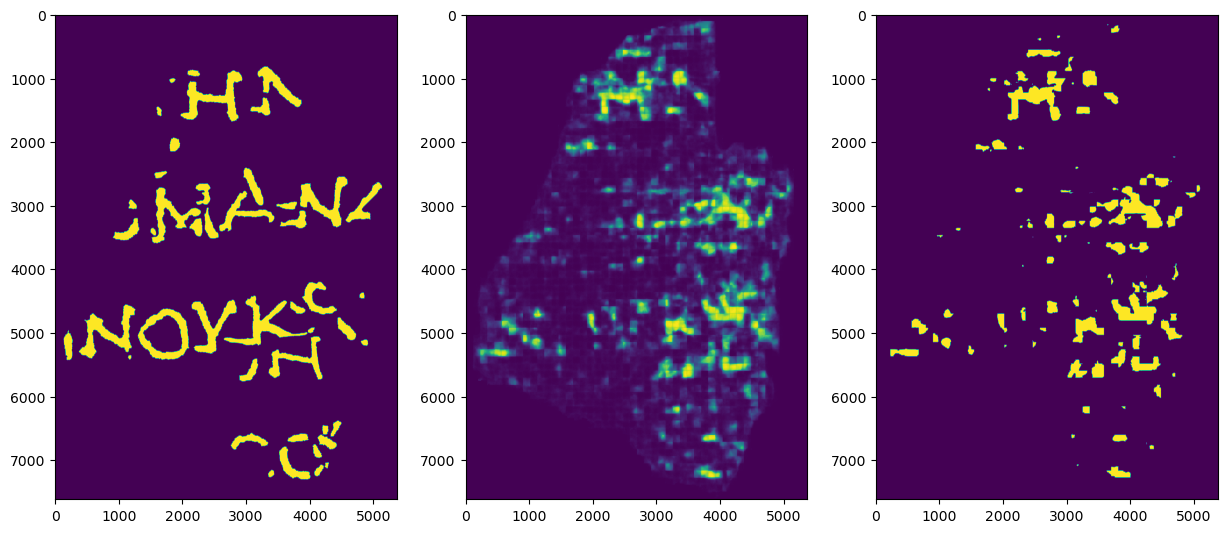

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([30167217.,  3782858.,  1593772.,   935976.,   646024.,   487144.,
          394162.,   335692.,   302461.,   264700.,   227082.,   212407.,
          208206.,   204152.,   193725.,   197336.,   202156.,   208366.,
          224746.,   155434.]),
 array([1.93776073e-05, 4.96257751e-02, 9.92321725e-02, 1.48838570e-01,
        1.98444967e-01, 2.48051365e-01, 2.97657762e-01, 3.47264160e-01,
        3.96870557e-01, 4.46476955e-01, 4.96083352e-01, 5.45689749e-01,
        5.95296147e-01, 6.44902544e-01, 6.94508942e-01, 7.44115339e-01,
        7.93721737e-01, 8.43328134e-01, 8.92934532e-01, 9.42540929e-01,
        9.92147326e-01]),
 <BarContainer object of 20 artists>)

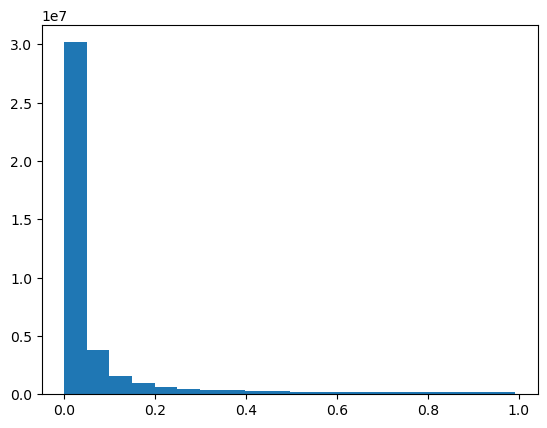

In [39]:
plt.hist(mask_pred.flatten(), bins=20)

In [40]:
# GPU VRAM 5.2GB/16.0GB A4000